In [ ]:
## importing libraries
import gradio as gr
from openai import OpenAI
import base64
from dotenv import load_dotenv
from PIL import Image
import io
import os


In [ ]:
load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [15]:
# Function to convert image to base64
def encode_image(image):
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

# Function to analyze image + text with GPT-4o
def analyze_image_text(image, text_input):
    if image is None:
        return "Please upload an image."

    # Convert image to base64
    img_base64 = encode_image(image)

    # Construct OpenAI request
    messages = [{"role": "system", "content": "You are an AI that analyzes images and text."}]
    
    if text_input:
        messages.append({"role": "user", "content": text_input})

    messages.append({"role": "user", "content": {"type": "image_url", "image_url": f"data:image/png;base64,{img_base64}"}})

    # Call OpenAI API
    openai.api_key = openai_api_key
    response =openai.chat.completions.create(model=MODEL, messages=messages)

    return response["choices"][0]["message"]["content"]

In [16]:
# Gradio UI
interface = gr.Interface(
    fn=analyze_image_text,
    inputs=[
        gr.Image(type="pil"),  # Upload image
        gr.Textbox(label="Enter additional text for analysis (optional)"),
    ],
    outputs="text",
    title="📸 Multimodal AI: Image & Text Analyzer",
    description="Upload an image and enter text (optional). The AI will analyze both and provide insights.",
)

In [24]:
import requests

In [37]:
# Function to resize image (reduces API load)
def resize_image(image, max_size=(800, 800)):
    image.thumbnail(max_size)
    return image

# Function to convert image to base64
def encode_image(image):
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

# Function to call OpenAI API with timeout
def call_openai_with_timeout(payload, timeout=30):
    headers = {"Authorization": f"Bearer {openai_api_key}", "Content-Type": "application/json"}
    try:
        response = requests.post("https://api.openai.com/v1/chat/completions", json=payload, headers=headers, timeout=timeout)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.Timeout:
        return {"error": "⏳ Request timed out. Please try again with a smaller image."}
    except requests.exceptions.RequestException as e:
        return {"error": f"❌ API Error: {str(e)}"}

# Function to analyze image + text with GPT-4o
def analyze_image_text(image, text_input):
    if image is None:
        return "⚠️ Please upload an image."

    # Resize and encode image
    image = resize_image(image)
    img_base64 = encode_image(image)

    # Construct OpenAI request with correct multimodal format
    messages = [
        {"role": "system", "content": "You are an AI that analyzes images and text."},
        {"role": "user", "content": f"{text_input if text_input else 'Describe this image.'}\n![image](data:image/png;base64,{img_base64})"}
    ]

    payload = {"model": MODEL, "messages": messages}

    # Debugging: Print payload to check its structure
    print("Payload:", payload)

    # Call OpenAI API with timeout
    response = call_openai_with_timeout(payload)

    if "error" in response:
        return response["error"]
    
    return response["choices"][0]["message"]["content"]


In [38]:
# Gradio UI
interface = gr.Interface(
    fn=analyze_image_text,
    inputs=[
        gr.Image(type="pil"),  
        gr.Textbox(label="Enter additional text for analysis (optional)"),
    ],
    outputs="text",
    title="📸 Multimodal AI: Image & Text Analyzer",
    description="Upload an image and enter text (optional). The AI will analyze both and provide insights.",
)

* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


Payload: {'model': 'gpt-4o-mini', 'messages': [{'role': 'system', 'content': 'You are an AI that analyzes images and text.'}, {'role': 'user', 'content': 'Describe this image.\n'}]}

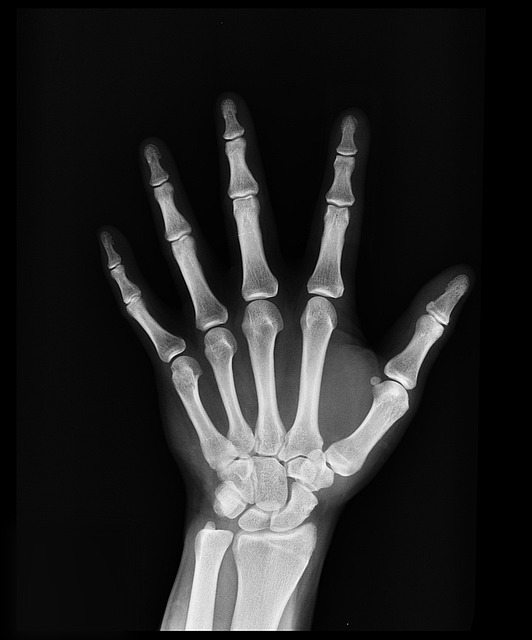

In [39]:
# Launch Gradio app
interface.launch()